<a href="https://colab.research.google.com/github/viraj-code1/NLP-Projects/blob/main/POS_tagging_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000

import seaborn as sns

from gensim.models import KeyedVectors

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving testEng.xlsx to testEng.xlsx


In [ ]:
import io
data =pd.read_excel(io.BytesIO(uploaded['trainEng.xlsx']))

In [ ]:
import io
testData =pd.read_excel(io.BytesIO(uploaded['testEng.xlsx']))

In [ ]:
data['Words']= data['Words'].astype(str)
data['POS']= data['POS'].astype(str)
len(data)

217126

In [ ]:
testData['Words']= testData['Words'].astype(str)
testData['POS']= testData['POS'].astype(str)
len(testData)

27173

In [ ]:
#check for null values
data.isnull().sum()

Words    0
POS      0
dtype: int64

In [ ]:
xdata=[]
ydata=[]

xsent=[]
ysent=[]

n = len(data)
for i in range(n):
  if data['Words'][i]!="nan":
    xsent.append(data['Words'][i])
    ysent.append(data['POS'][i])
  elif len(xsent)>0 : 
    xdata.append(xsent.copy())
    ydata.append(ysent.copy())
    xsent.clear()
    ysent.clear()

xdata.append(xsent.copy())
ydata.append(ysent.copy())
    



In [ ]:
xtest=[]
ytest=[]

xsent=[]
ysent=[]

n = len(testData)
for i in range(n):
  if testData['Words'][i]!="nan":
    xsent.append(testData['Words'][i])
    ysent.append(testData['POS'][i])
  elif len(xsent)>0 : 
    xtest.append(xsent.copy())
    ytest.append(ysent.copy())
    xsent.clear()
    ysent.clear()

xtest.append(xsent.copy())
ytest.append(ysent.copy())

In [ ]:
print("no. of sentence =",len(xdata))
num_words = len(set([word.lower() for sentence in xdata for word in sentence]))
num_tags   = len(set([word.lower() for sentence in ydata for word in sentence]))
print("Distinct words = {}".format(num_words))
print("Distinct tags = {}".format(num_tags))

no. of sentence = 12551
Distinct words = 13283
Distinct tags = 18


In [ ]:
print("no. of sentence =",len(xtest))
num_words = len(set([word.lower() for sentence in xtest for word in sentence]))
num_tags   = len(set([word.lower() for sentence in ytest for word in sentence]))
print("Distinct words = {}".format(num_words))
print("Distinct tags = {}".format(num_tags))

no. of sentence = 2077
Distinct words = 4217
Distinct tags = 18


#Vectorize data

In [ ]:
word_tokenizer = Tokenizer()                      
word_tokenizer.fit_on_texts(xdata)                    
x_encoded = word_tokenizer.texts_to_sequences(xdata)

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(ydata)
y_encoded = tag_tokenizer.texts_to_sequences(ydata)

In [ ]:
word_tokenizer_test = Tokenizer()                      
word_tokenizer_test.fit_on_texts(xtest)                    
x_encoded_test = word_tokenizer_test.texts_to_sequences(xtest)

tag_tokenizer_test = Tokenizer()
tag_tokenizer_test.fit_on_texts(ytest)
y_encoded_test = tag_tokenizer_test.texts_to_sequences(ytest)

In [ ]:

print('X: ', xdata[0], '\n')
print('Y: ', ydata[0], '\n')
print()
print('X: ', x_encoded[0], '\n')
print('Y: ', y_encoded[0], '\n')

In [ ]:
X_encoded = x_encoded
Y_encoded = y_encoded


In [ ]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))
MAX_SEQ_LENGTH = max(lengths)

Length of longest sentence: 159


In [ ]:
X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [ ]:
X_test = pad_sequences(x_encoded_test, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_test = pad_sequences(y_encoded_test, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [ ]:
X, Y = X_padded, Y_padded

In [ ]:
# word2vec
path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# load word2vec using the following function present in the gensim library
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)
# assign word vectors from word2vec model
# each word in word2vec model is represented using a 300 dimensional vector
EMBEDDING_SIZE  = 300  
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
# create a word to index dictionary mapping
word2id = word_tokenizer.word_index
# copy vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [ ]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (13284, 300)


In [ ]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(Y)
Y_test = to_categorical(Y_test)

In [ ]:
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=VALID_SIZE, random_state=4)

In [ ]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (10668, 159)
Shape of output sequences: (10668, 159, 19)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1883, 159)
Shape of output sequences: (1883, 159, 19)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (2077, 159)
Shape of output sequences: (2077, 159, 19)


##VANILLA RNN

In [ ]:
# total number of tags
NUM_CLASSES = Y.shape[2]

In [ ]:
# create architecture

rnn_model = Sequential()

# create embedding layer - usually the first layer in text problems
rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,         # vocabulary size - number of unique words in data
                        output_dim    =  EMBEDDING_SIZE,          # length of vector with which each word is represented
                        input_length  =  MAX_SEQ_LENGTH,          # length of input sequence
                        trainable     =  True                  # False - don't update the embeddings
))

# add an RNN layer which contains 64 RNN cells
rnn_model.add(SimpleRNN(64, 
              return_sequences=True  # True - return whole sequence; False - return single output of the end of the sequence
))

# add time distributed (output at each sequence) layer
rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [ ]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [ ]:
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 159, 300)          3985200   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 159, 64)           23360     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 159, 19)           1235      
Total params: 4,009,795
Trainable params: 4,009,795
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
84/84 [==============================] - 18s 211ms/step - loss: 0.0181 - acc: 0.9944 - val_loss: 0.0309 - val_acc: 0.9906
Epoch 2/10
84/84 [==============================] - 18s 210ms/step - loss: 0.0169 - acc: 0.9948 - val_loss: 0.0304 - val_acc: 0.9906
Epoch 3/10
84/84 [==============================] - 18s 210ms/step - loss: 0.0159 - acc: 0.9950 - val_loss: 0.0300 - val_acc: 0.9907
Epoch 4/10
84/84 [==============================] - 18s 210ms/step - loss: 0.0151 - acc: 0.9953 - val_loss: 0.0298 - val_acc: 0.9908
Epoch 5/10
84/84 [==============================] - 18s 210ms/step - loss: 0.0143 - acc: 0.9955 - val_loss: 0.0296 - val_acc: 0.9909
Epoch 6/10
84/84 [==============================] - 18s 212ms/step - loss: 0.0136 - acc: 0.9957 - val_loss: 0.0295 - val_acc: 0.9909
Epoch 7/10
84/84 [==============================] - 18s 210ms/step - loss: 0.0129 - acc: 0.9959 - val_loss: 0.0294 - val_acc: 0.9910
Epoch 8/10
84/84 [==============================] - 18s 211ms/step - 

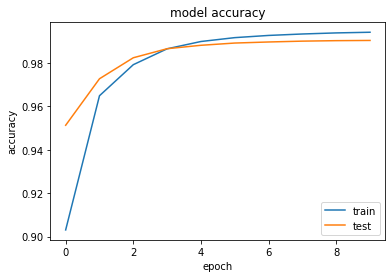

In [ ]:
# visualise training history
plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()